In [0]:
from matplotlib import pyplot as plt
import pandas as pd

In [0]:
%pip install spark-nlp==5.5.2

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


# GET TEXT FROM TABLE

In [0]:
def get_random_book_text():
    text = spark.sql("SELECT book_text FROM book_to_process WHERE book_id = 78")
    return text

# CLEAN TEXT 

In [0]:
import re
from pyspark.sql.functions import regexp_replace
from pyspark.sql.types import StringType

def process_book_text(book_to_process):
    book_text_to_process = book_to_process.collect()[0].book_text
    split_text = book_text_to_process.split("CHAPTER")
    filtered_chapters = [chapter for chapter in split_text if len(chapter) >= 100]
    filtered_chapters = filtered_chapters[1:]
    chapter_dataframe = spark.createDataFrame(filtered_chapters, StringType())
    chapter_dataframe = chapter_dataframe.withColumnRenamed("value", "book_text")
    chapter_dataframe = chapter_dataframe.withColumn(
        "book_text", 
        regexp_replace(regexp_replace("book_text", r"\r\n|\n|\t", " "), r"\s+", " ")
    )
    return chapter_dataframe


# SENTIMENT PIPELINE FROM NLP JOHN SNOW LABS

In [0]:
from sparknlp.base import DocumentAssembler, Pipeline, Finisher
from sparknlp.annotator import (
    SentenceDetector,
    Tokenizer,
    Lemmatizer,
    SentimentDetector
)



def sentiment_pipeline():
        document_assembler = (
            DocumentAssembler()
            .setInputCol("book_text")
            .setOutputCol("document")
        )

        sentence_detector = SentenceDetector().setInputCols(["document"]).setOutputCol("sentence")

        tokenizer = Tokenizer().setInputCols(["sentence"]).setOutputCol("token")

        lemmatizer = Lemmatizer() \
            .setInputCols(["token"]) \
            .setOutputCol("lemma") \
            .setDictionary("dbfs:/FileStore/tables/lemmas_small.txt", key_delimiter="->", value_delimiter="\t")

        sentiment_detector= (
            SentimentDetector()
            .setInputCols(["lemma", "sentence"])
            .setOutputCol("sentiment_score")
            .setDictionary("dbfs:/FileStore/tables/default-sentiment-dict.txt", ",")
        )

        finisher= (
            Finisher()
            .setInputCols(["sentiment_score"]).setOutputCols("sentiment")
        )

        pipeline = Pipeline(
            stages=[
                document_assembler,
                sentence_detector, 
                tokenizer, 
                lemmatizer, 
                sentiment_detector, 
                finisher
            ]
        )

        return pipeline
    
book_to_process = get_random_book_text()
text_data = process_book_text(book_to_process)
pipeline = sentiment_pipeline()

# RESULTS

In [0]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import row_number,lit,col
from pyspark.sql.window import Window

sentiment_result = pipeline.fit(text_data).transform(text_data)
sentiment_result = sentiment_result.withColumn('sentiment', col('sentiment')[0])

def get_sentiment_score(sentiment):
    if sentiment == 'positive':
        return 1
    elif sentiment == 'negative':
        return -1
    else:
        return 0

sentiment_udf = udf(get_sentiment_score, IntegerType())

sentiment_result = sentiment_result.withColumn('sentiment_score', sentiment_udf(col('sentiment')))

w = Window().orderBy(lit('A'))
sentiment_result = sentiment_result.withColumn("chapter_number", row_number().over(w))

# VISUALIZATION

([<matplotlib.axis.XTick at 0x7f33776967a0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23'),
  Text(24, 0, '24'),
  Text(25, 0, '25'),
  Text(26, 0, '26'),
  Text(27, 0, '27'),
  Text(28, 0, '28')])

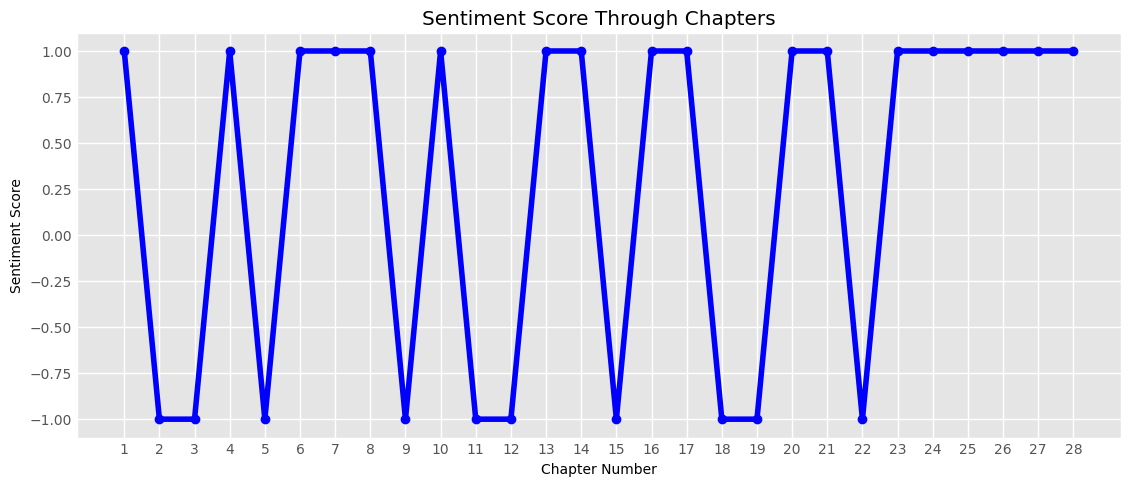

In [0]:
pd_df = sentiment_result.select('sentiment_score', 'chapter_number').toPandas()

pd_df["chapter_number"] = pd_df["chapter_number"].astype(int)
pd_df["sentiment_score"] = pd_df["sentiment_score"].astype(int)

pd_df = pd_df.sort_values(by=['chapter_number'])

plt.figure(figsize=(12,5))
plt.plot(pd_df.chapter_number, pd_df.sentiment_score, marker="o", linestyle="-", color="b")
plt.title("Sentiment Score Through Chapters")
plt.xlabel("Chapter Number")
plt.ylabel("Sentiment Score")
plt.xticks(pd_df['chapter_number'])